### 1. Headers

In [1]:
# Computation Libraries
import numpy as np
import pandas as pd
import os
import scipy
from PIL import Image

# Stats Libraries
import statistics
import scipy.stats as stats

# Visualisazition Libraries
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Encoders and Scalars
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Modelling Libraries
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Evaluation Metrics Libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Cross Validation Libraries
from sklearn.model_selection import cross_val_score


# Helpers
from IPython.display import clear_output, display

In [2]:
import tensorflow as tf

### 2. Helper Functions

In [62]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-1*Z))
    cache = Z
    
    return A

def relu(Z):
    """
    Implement the RELU function.
    Arguments:
    Z -- Output of the linear layer, of any shape
    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A


In [64]:
def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well. 
    Z[Z<=0] = 0
    Z[Z>0] = 1
    dZ = np.multiply(dZ,Z)

    assert (dZ.shape == Z.shape)

    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """

    Z = cache

    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)

    assert (dZ.shape == Z.shape)

    return dZ

### 3. Intialize Dimensions and Parameters

In [47]:

# defaults for training
IMG_HEIGHT = 32
IMG_WIDTH  = 32

epsilon = 1e-5

# We would be resizing the images to 64x64x3 for having same size for training
n_x = IMG_HEIGHT*IMG_WIDTH*3
hidden_layer_dims = [n_x,16,8,4,2,1] 

### 4. Initialize Random Weights

In [74]:
def initialize_weights(layers_dims):
    params = {}
    for i in range(1, len(layers_dims)): 
        params["W"+str(i)] = np.random.randn(layers_dims[i],layers_dims[i-1])
        params["b"+str(i)] = np.zeros((layers_dims[i],1))
    return params

### 5. Forward Propogation

In [24]:
def forward_propogation(X, params, layers_dims):
    cache = {}
    L = len(layers_dims)-1
    cache["A"+str(0)] = X
    cache["Z"+str(1)] = np.dot(params["W1"],X)+params["b1"]
    cache["A"+str(1)] = relu(cache["Z1"])
    for i in range(1,L-1):
        cache["Z"+str(i+1)] = np.dot(params["W"+str(i+1)],cache["A"+str(i)])+params["b"+str(i+1)]
        cache["A"+str(i+1)] = relu(cache["Z"+str(i+1)])
        
    # Batch Normalization
#     cache["A"+str(L-1)] = cache["A"+str(L-1)]/((np.max(cache["A"+str(L-1)])-np.min(cache["A"+str(L-1)])))
    cache["Z"+str(L)] = np.dot(params["W"+str(L)],cache["A"+str(L-1)])+params["b"+str(L)]
    cache["A"+str(L)] = sigmoid(cache["Z"+str(L)])
    
#     print(cache["Z"+str(L)])
    return cache

### 6. Cost

In [25]:
def calculate_cost(AL, Y, layers_dims):
    m = Y.shape[1]
    cost = (-1/m)*np.sum(np.multiply(Y,np.log(AL+epsilon))+np.multiply(1-Y,np.log(1-AL+epsilon)))
    cost = np.squeeze(cost)
    return cost

### 7. Backward_Propagation

In [26]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    
    m = A_prev.shape[1]
    dW = (1/m)*(np.dot(dZ,A_prev.T))
    db = (1/m)*np.sum(dZ,axis=1,keepdims=True) 
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [27]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ =   relu_backward(dA, activation_cache)  
    elif activation == "sigmoid":
        dZ =   sigmoid_backward(dA, activation_cache)
        
    dA_prev, dW, db =  linear_backward(dZ, linear_cache)  
    return dA_prev, dW, db

In [81]:
def backward_propagation(Y,AL,params,cache, layers_dims):
    grads = {}
    m = Y.shape[1]
    Y = Y.reshape(AL.shape)
    
    L = len(layers_dims)-1
    
    dAL = AL-Y
    print(dAL)
    cache_val = ((cache["A"+str(L-1)],params["W"+str(L)],params["b"+str(L)]),cache["Z"+str(L)])
    
    dA_prev,dW,db = linear_activation_backward(dAL, cache_val, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev
    grads["dW" + str(L)] = dW
    grads["db" + str(L)] = db
    
    for i in range(L-1,0,-1):
        cache_val = ((cache["A"+str(i-1)],params["W"+str(i)],params["b"+str(i)]),cache["Z"+str(i)])
        dA_prev, dW, db = linear_activation_backward(dA_prev, cache_val, "relu")
        if(i>0):
            grads["dA" + str(i-1)] = dA_prev
        grads["dW" + str(i)] = dW
        grads["db" + str(i)] = db
    
    return grads

### 8. Update Parameters

In [29]:
def update_parameters(params, grads, learning_rate):

    parameters = params.copy()
    L = len(parameters) // 2
    
    for l in range(L):
#         print("Param :" , params["W"+ str(l+1)])
#         print("Grads :" , grads["dW"+ str(l+1)])
        parameters["W" + str(l+1)] = params["W"+ str(l+1)] - learning_rate*grads["dW"+ str(l+1)]
        parameters["b" + str(l+1)] = params["b"+ str(l+1)] - learning_rate*grads["db"+ str(l+1)]
        
    return parameters

### 9. Train model

In [30]:
def plot_attr(values, learning_rate=0.5,x_l = 'iterations (per hundreds)', y_l = 'cost', title="Cost_Plot"):
    clear_output(wait=True)
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
    plt.plot(np.squeeze(values))
    plt.ylabel(y_l)
    plt.xlabel(x_l)
    plt.title(title)
    plt.show()
    
    

In [82]:
def train_model(X, Y, layers_dims, params = [], learning_rate=0.25, num_iterations = 3000, print_cost=False):

    costs = [] 
    df_ = pd.DataFrame(index=['x', 'y'])
    if(params == []):
        params = initialize_weights(layers_dims)
    
    for i in range(0, num_iterations):
#         print(params)
        caches = forward_propogation(X, params, layers_dims)
        AL = caches["A"+str(len(layers_dims)-1)]
        cost = calculate_cost(AL, Y, layers_dims)
        grads = backward_propagation(Y,AL,params,caches, layers_dims)    
        

        if i % 10 == 0 or i == num_iterations:
            costs.append(cost)
            plot_attr(costs)
#             print("Params : ",params)
#             print("Grads : ",grads

        if print_cost and i % 10 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
#             print("Params : ",params)
#             print("AL : ",caches["A"+str(len(layers_dims)-1)])
#             print("dW1 : ", learning_rate*grads["dW1"])
#             print("dW2 : ", learning_rate*grads["dW2"])
#             clear_output(wait=True)
#             print(df_.to_markdown())
        df1 = pd.DataFrame({'x':np.amax(caches["Z5"]),'y':np.amin(caches["Z5"])}, index = ["x","y"])
        df_ = df1.append(df_, ignore_index=True)
        params = update_parameters(params, grads, learning_rate)
            
            
    return params, costs

### 10. Import Dataset

In [32]:
## We store the data directly in a verctorized format 
dataset_path = "/Users/saikarna/Desktop/GitHub/Daily-Notebook/dogs-vs-cats/"
train_path = dataset_path+"train/"
test_path = dataset_path+"test1/"
image_x = []
image_x_1 = []

def load_dataset(train_path):
    X, Y =[],[]
    i=0
    for filename in os.listdir(train_path):
        if(filename[-3:]=="jpg"):
            file_path = train_path+filename
            image_open= Image.open(file_path)
            image= np.array(image_open.resize((IMG_HEIGHT,IMG_WIDTH)))
            image = image.astype('float32')
            image /= 255.  
            if(i==0):
                fig = plt.figure()
                ax1 = fig.add_subplot(1,2,1)
                ax1.imshow(image_open)
                ax2 = fig.add_subplot(1,2,2)
                ax2.imshow(image)
                i+=1
            X.append(image)
            Y.append(1 if filename[0]=="d" else 0)
    X,Y = np.array(X), np.array(Y)
    return X, Y

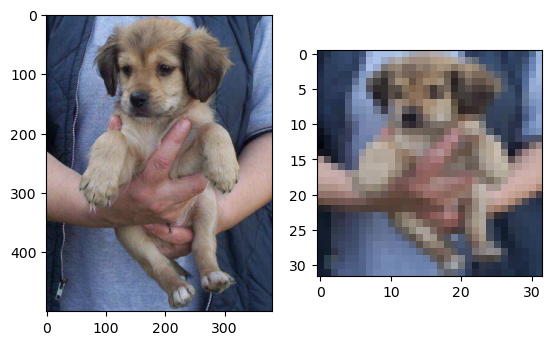

In [33]:
X , Y = load_dataset(train_path)

In [34]:
X = np.array(X)
Y = np.array(Y)

In [35]:
print("Number of data points in X : ",X.shape)
print("Number of data points in Y : ",Y.shape)

## Number of Cats and Dogs
pd.Series(Y).value_counts()

Number of data points in X :  (25000, 32, 32, 3)
Number of data points in Y :  (25000,)


1    12500
0    12500
dtype: int64

### 11. Vectorize Data

In [36]:
print("Number of data points in X : ",X.shape)
print("Number of data points in Y : ",Y.shape)


X_train, X_test, Y_train ,Y_test = train_test_split(X,Y,test_size = 0.33, random_state = 33)
print("X-train Shape : ",X_train.shape, "Y-train Shape : ",Y_train.shape)
print("X-test Shape : ",X_test.shape, "Y-test Shape : ",Y_test.shape)

Number of data points in X :  (25000, 32, 32, 3)
Number of data points in Y :  (25000,)
X-train Shape :  (16750, 32, 32, 3) Y-train Shape :  (16750,)
X-test Shape :  (8250, 32, 32, 3) Y-test Shape :  (8250,)


In [37]:
X_train_flatten = np.array(X_train.reshape(X_train.shape[0],-1).T)
Y_train_flatten = np.array(Y_train.reshape(Y_train.shape[0],-1).T)

X_test_flatten = np.array(X_test.reshape(X_test.shape[0],-1).T)
Y_test_flatten = np.array(Y_test.reshape(Y_test.shape[0],-1).T)

print("X-train Shape : ",X_train_flatten.shape, "Y-train Shape : ",Y_train_flatten.shape)
print("X-test Shape : ",X_test_flatten.shape, "Y-test Shape : ",Y_test_flatten.shape)

X-train Shape :  (3072, 16750) Y-train Shape :  (1, 16750)
X-test Shape :  (3072, 8250) Y-test Shape :  (1, 8250)


### 12. Train Model

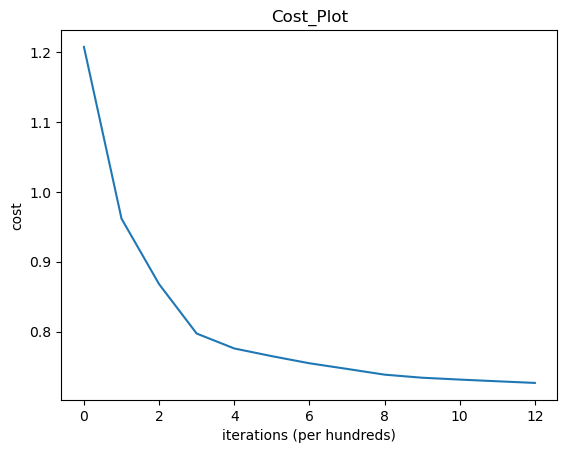

Cost after iteration 120: 0.7263745713122319
[[-0.50107701  0.49892299 -0.50107701 ... -0.50107701 -0.50107701
   0.49892299]]


/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)
/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)


[[-0.50108433  0.49891567 -0.50108433 ... -0.50108433 -0.50108433
   0.49891567]]


/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)


[[-0.50109157  0.49890843 -0.50109157 ... -0.50109157 -0.50109157
   0.49890843]]


/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)


[[-0.50109875  0.49890125 -0.50109875 ... -0.50109875 -0.50109875
   0.49890125]]


/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)


[[-0.50110584  0.49889416 -0.50110584 ... -0.50110584 -0.50110584
   0.49889416]]


/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)


[[-0.50111282  0.49888718 -0.50111282 ... -0.50111282 -0.50111282
   0.49888718]]


/var/folders/n6/_d51nz9150383_pg0dg8mxqm0000gn/T/ipykernel_50686/73930379.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df1.append(df_, ignore_index=True)


KeyboardInterrupt: 

In [83]:
model_param, costs = train_model(X_train_flatten, Y_train_flatten, hidden_layer_dims,params = [], learning_rate = 0.1, num_iterations = 5000, print_cost=True)

### 13. Predict and Visualize

In [ ]:
def predict(params,X_test, layers_dims):
    cache = forward_propogation(X_test, params, layers_dims)
    op = cache["A"+str(len(layers_dims)-1)]
    op[op>=0.5] = 1
    op[op<0.5] = 0
    return op

Y_pred = predict(model_param,X_train_flatten, hidden_layer_dims)

In [ ]:
accuracy_score(np.squeeze(Y_train_flatten),np.squeeze(Y_pred))

In [ ]:
import tensorflow as tf
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

### Questions to ponder on
1. Why not train with images with different sizes??
2. How can we have autocomplete feature available for Jupyter notebook